In [10]:
import os 
import pandas as pd
from ortools.linear_solver import pywraplp
import time
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString

In [4]:
def solve_conservation_model(df_path, budget, alpha=5, time_limit_sec=300):
    """
    Implementación del Modelo ILP de Conservación (Menorca).

    Args:
        df_path (str): Ruta al CSV enriquecido (final_dataset.csv).
        budget (float): Presupuesto total disponible (B).
        alpha (float): Bonus de conectividad para corredores.
        time_limit_sec (int): Tiempo máximo para el solver.
    """
    print(f"\n--- INICIANDO OPTIMIZACIÓN (Presupuesto: {budget}€) ---")

    # 1. CARGA DE DATOS
    # ---------------------------------------------------------
    df = pd.read_csv(df_path)
    df.set_index('grid_id', inplace=True) # Usamos grid_id como índice para acceso rápido

    # Definimos Conjuntos (Sets)
    I = df.index.tolist() # Todas las celdas
    S = ['atelerix', 'martes', 'eliomys', 'oryctolagus'] # Especies

    # 2. INICIALIZAR SOLVER
    # ---------------------------------------------------------
    # Usamos SCIP (Solving Constraint Integer Programs), estándar para MIP gratuito
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        print("¡Error! Solver SCIP no encontrado.")
        return None

    solver.SetTimeLimit(time_limit_sec * 1000) # Milisegundos

    # 3. VARIABLES DE DECISIÓN
    # ---------------------------------------------------------
    print("Generando variables...")

    x = {} # Selección de Hábitat: x[i, s]
    y = {} # Inversión en Adaptación: y[i, s]
    z = {} # Corredores: z[i, j]

    # Generamos x e y
    for i in I:
        for s in S:
            x[i, s] = solver.IntVar(0, 1, f'x_{i}_{s}')
            y[i, s] = solver.IntVar(0, 1, f'y_{i}_{s}')

    # Generamos z (Corredores)
    # IMPORTANTE: Solo creamos variable si i y j son vecinos y para evitar duplicados (i < j)
    # Esto reduce el número de variables a la mitad.
    possible_corridors = []

    for i in I:
        neighbors_str = df.loc[i, 'neighbors']
        if pd.isna(neighbors_str): continue

        neighbors = neighbors_str.split(',')
        for j in neighbors:
            if j in df.index and i < j: # Orden léxico para unicidad (Edge i-j es igual a j-i)
                z[i, j] = solver.IntVar(0, 1, f'z_{i}_{j}')
                possible_corridors.append((i, j))

    print(f"Variables creadas: {solver.NumVariables()}")

    # 4. RESTRICCIONES (Constraints)
    # ---------------------------------------------------------
    print("Aplicando restricciones...")

    # R1. Consistencia de Hábitat (Logic of Investment)
    # x <= P + y
    for i in I:
        for s in S:
            # Nombre de la columna original: 'has_atelerix_algirus', etc.
            # Mapeamos nombre corto a nombre de columna
            full_name = {
                'atelerix': 'has_atelerix_algirus',
                'martes': 'has_martes_martes',
                'eliomys': 'has_eliomys_quercinus',
                'oryctolagus': 'has_oryctolagus_cuniculus'
            }[s]

            p_is = int(df.loc[i, full_name]) # 1 si está presente, 0 si no
            solver.Add(x[i, s] <= p_is + y[i, s])

    # R2. Presupuesto (Budget Constraint)
    # Sum(Cost_Adapt * y) + Sum(Cost_Corr * z) <= B
    total_cost_expr = 0

    # Costes de Adaptación
    for i in I:
        for s in S:
            cost_adapt = df.loc[i, f'cost_adaptation_{s}']
            total_cost_expr += cost_adapt * y[i, s]

    # Costes de Corredores (Media de ambos extremos)
    for (i, j) in possible_corridors:
        cost_i = df.loc[i, 'cost_corridor']
        cost_j = df.loc[j, 'cost_corridor']
        avg_cost = (cost_i + cost_j) / 2.0
        total_cost_expr += avg_cost * z[i, j]

    solver.Add(total_cost_expr <= budget)

    # R3. Incompatibilidad Biológica (Hard Constraints)
    # Solo iteramos sobre las celdas conflictivas (Optimización de código)

    # A. Marta vs Lirón (Conflict ME)
    conflict_me = df[df['conflict_martes_eliomys'] == 1].index
    for i in conflict_me:
        solver.Add(x[i, 'martes'] + x[i, 'eliomys'] <= 1)

    # B. Marta vs Conejo (Conflict MO)
    conflict_mo = df[df['conflict_martes_oryctolagus'] == 1].index
    for i in conflict_mo:
        solver.Add(x[i, 'martes'] + x[i, 'oryctolagus'] <= 1)

    # R4. Topología de Corredores
    # z_ij <= Sum(x_i)  y  z_ij <= Sum(x_j)
    # Un corredor solo existe si ambos extremos están activos para AL MENOS una especie
    for (i, j) in possible_corridors:
        # Suma de todas las especies en la celda i
        sum_species_i = sum(x[i, s] for s in S)
        sum_species_j = sum(x[j, s] for s in S)

        solver.Add(z[i, j] <= sum_species_i)
        solver.Add(z[i, j] <= sum_species_j)

    # 5. FUNCIÓN OBJETIVO
    # ---------------------------------------------------------
    # Maximize Z = Sum(Area * Quality * x) + alpha * Sum(z)
    obj_expr = 0

    # Valor del Hábitat
    for i in I:
        area = df.loc[i, 'cell_area_km2']
        for s in S:
            quality = df.loc[i, f'suitability_{s}']
            obj_expr += (area * quality) * x[i, s]

    # Bonus de Conectividad
    for (i, j) in possible_corridors:
        obj_expr += alpha * z[i, j]

    solver.Maximize(obj_expr)

    # 6. RESOLVER
    # ---------------------------------------------------------
    print(f"Resolviendo modelo con {solver.NumConstraints()} restricciones...")
    status = solver.Solve()

    # ... (Parte anterior del solver igual) ...

    # 7. RESULTADOS
    # ---------------------------------------------------------
    # ... (dentro de solve_conservation_model, cuando status es OPTIMAL/FEASIBLE) ...

    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print(f"¡Solución Encontrada! Valor Z: {solver.Objective().Value():.2f}")

        results = []
        for i in I:
            row = {'grid_id': i}

            # 1. Guardamos Estado (x) e Inversión (y)
            for s in S:
                row[f'active_{s}'] = int(x[i, s].solution_value()) # Total
                row[f'invest_{s}'] = int(y[i, s].solution_value()) # Solo Nuevos

            # 2. Guardamos Corredores (z)
            # Buscamos qué vecinos están conectados a 'i'
            connected_neighbors = []
            neighbors_str = df.loc[i, 'neighbors']

            if isinstance(neighbors_str, str):
                for j in neighbors_str.split(','):
                    # Reconstruimos la clave del diccionario (siempre ordenada)
                    key = (i, j) if i < j else (j, i)

                    # Si la variable existe y es 1, hay corredor
                    if key in z and z[key].solution_value() > 0.5:
                        connected_neighbors.append(j)

            row['corridors'] = ",".join(connected_neighbors)
            results.append(row)

        return pd.DataFrame(results)

In [14]:
BASE_PATH = os.getcwd()   
INPUT_FILE = os.path.join(BASE_PATH, '2_data', 'processed', 'final_dataset.csv')
PRESUPUESTO_REAL_EUROS = 1000000
PRESUPUESTO_MODELO = PRESUPUESTO_REAL_EUROS / 1000.0

print(f"Ruta de datos: {INPUT_FILE}")
print(f"Presupuesto Modelo: {PRESUPUESTO_MODELO} k€")

# --- EJECUCIÓN ---
if os.path.exists(INPUT_FILE):
    try:
        solucion = solve_conservation_model(INPUT_FILE, PRESUPUESTO_MODELO)
    except NameError:
        print("ERROR: La función 'solve_conservation_model' no está definida. Ejecuta la celda donde la tengas.")
        solucion = None

    if solucion is not None:
        print("\n--- RESUMEN DE LA SOLUCIÓN ---")

        # Carpeta de salida
        output_dir = os.path.join(BASE_PATH, '5_results', 'tables')
        output_file = os.path.join(output_dir, f"solution_budget_{int(PRESUPUESTO_MODELO)}k.csv")

        os.makedirs(output_dir, exist_ok=True)

        solucion.to_csv(output_file, index=False)
        print(f"Solución guardada en: {output_file}")
    else:
        print("El modelo no encontró solución (Infeasible).")
else:
    print(f"ERROR: No existe el archivo: {INPUT_FILE}")



Ruta de datos: c:\Users\borog\OneDrive - UPV\4º Curso\OPT (Optimización)\opt-project1-2025\2_data\processed\final_dataset.csv
Presupuesto Modelo: 1000.0 k€

--- INICIANDO OPTIMIZACIÓN (Presupuesto: 1000.0€) ---
Generando variables...
Variables creadas: 16511
Aplicando restricciones...
Resolviendo modelo con 17204 restricciones...
¡Solución Encontrada! Valor Z: 2710.13

--- RESUMEN DE LA SOLUCIÓN ---
Solución guardada en: c:\Users\borog\OneDrive - UPV\4º Curso\OPT (Optimización)\opt-project1-2025\5_results\tables\solution_budget_1000k.csv


In [9]:
df_sol = pd.read_csv('./5_results/tables/solution_budget_1000k.csv')

print("--- INVERSIONES REALIZADAS (Nuevas Celdas) ---")
inversiones = {
    'Erizo (Atelerix)': df_sol['invest_atelerix'].sum(),
    'Marta (Martes)': df_sol['invest_martes'].sum(),
    'Lirón (Eliomys)': df_sol['invest_eliomys'].sum(),
    'Conejo (Oryctolagus)': df_sol['invest_oryctolagus'].sum()
}

for especie, cantidad in inversiones.items():
    print(f"{especie}: {cantidad} celdas")

print("\n--- CORREDORES CREADOS ---")
# Contamos cuántas filas tienen texto en 'corridors' (no están vacías)
corredores_activos = df_sol['corridors'].notna().sum()
print(f"Celdas con corredores activos: {corredores_activos}")

--- INVERSIONES REALIZADAS (Nuevas Celdas) ---
Erizo (Atelerix): 76 celdas
Marta (Martes): 61 celdas
Lirón (Eliomys): 40 celdas
Conejo (Oryctolagus): 47 celdas

--- CORREDORES CREADOS ---
Celdas con corredores activos: 251


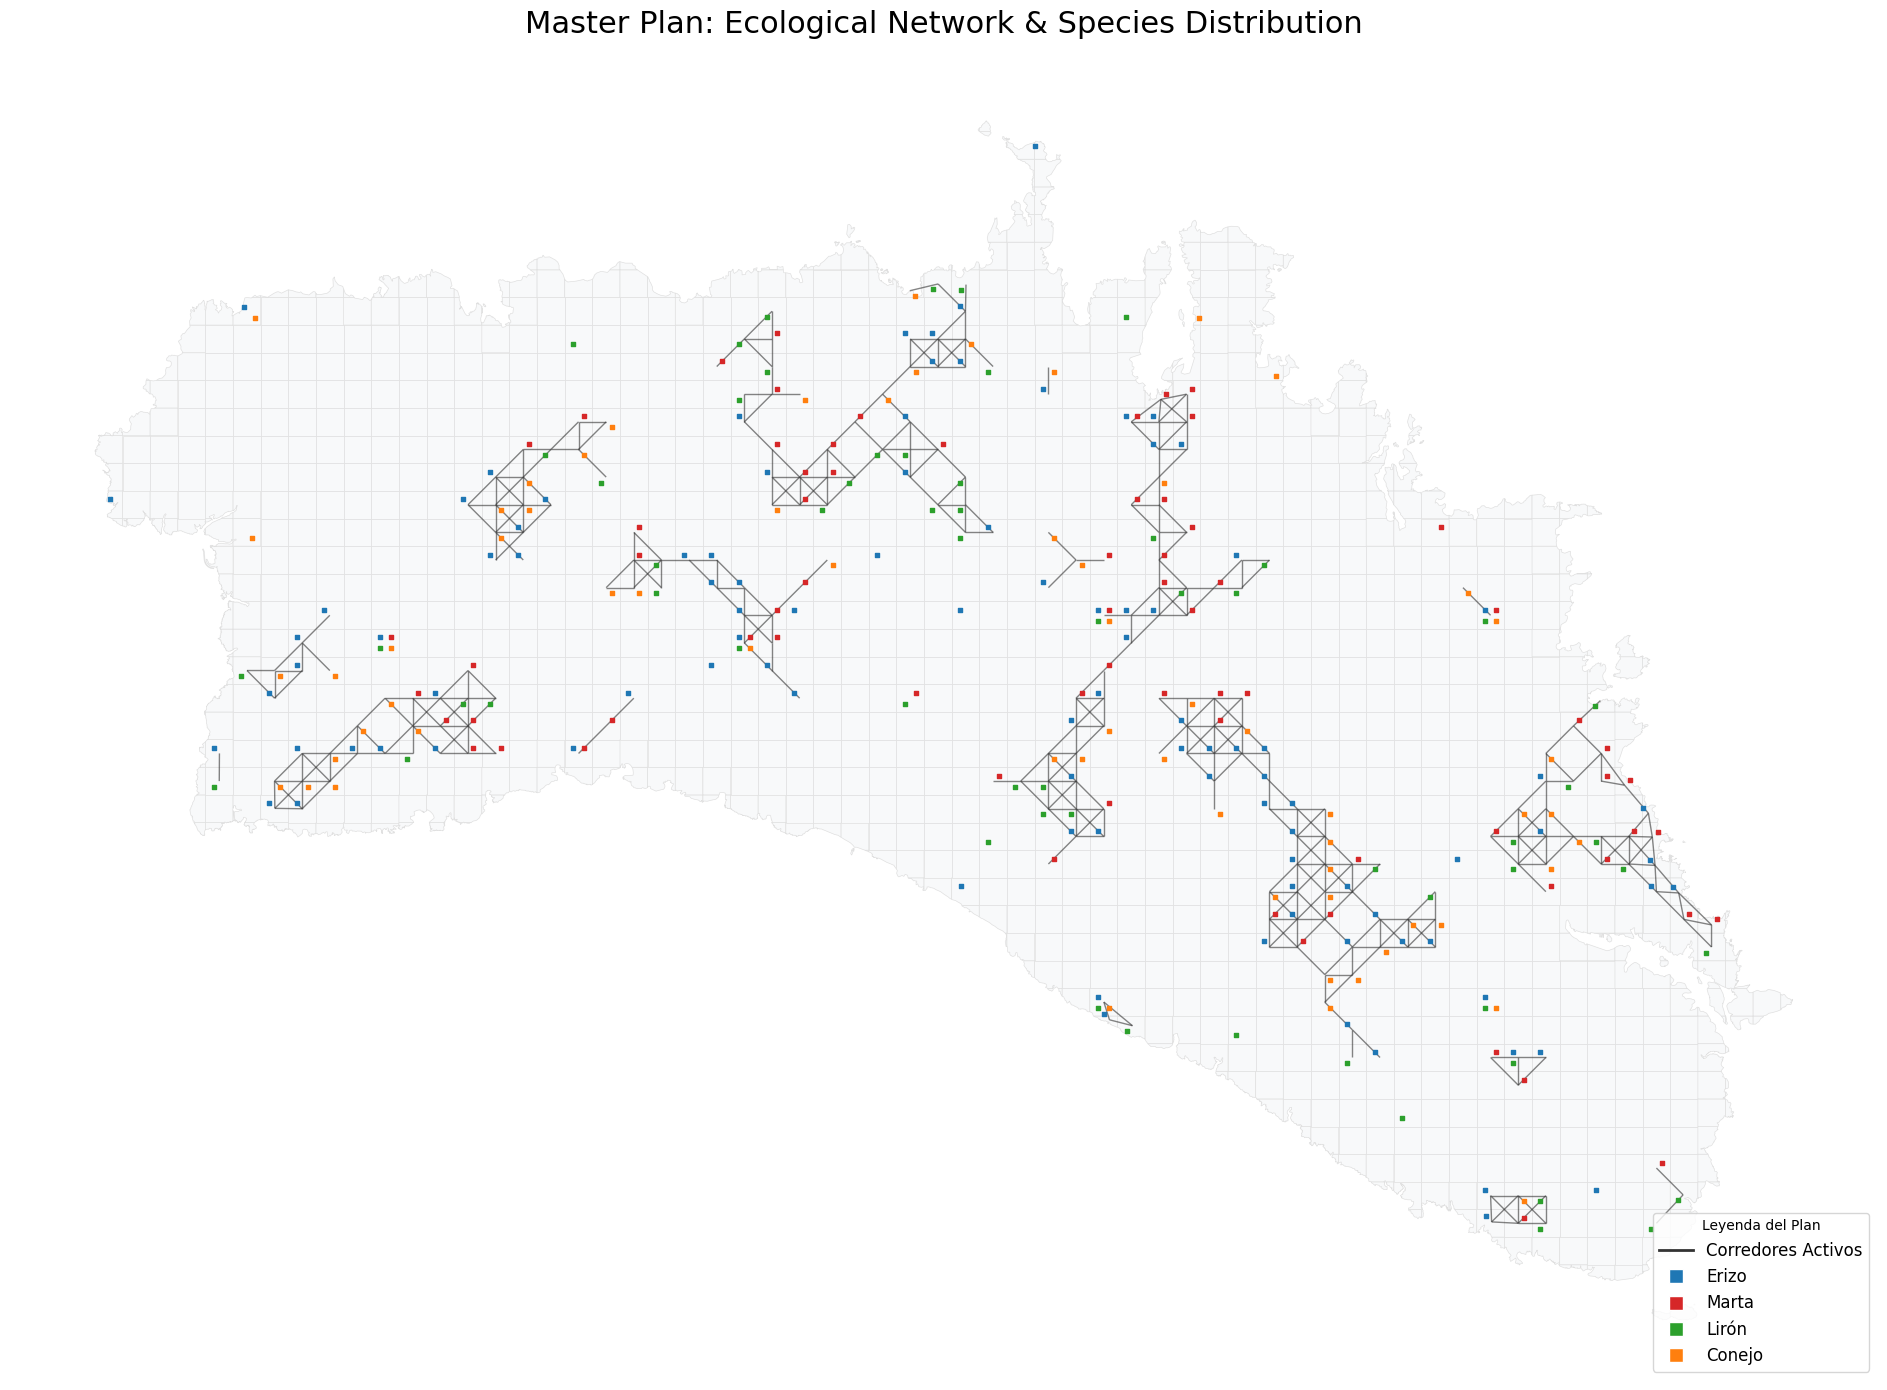

In [12]:
# 1. Configuración y Carga
# -------------------------------------------------
geojson_path = "./2_data/processed/final_dataset.geojson"
# Asegúrate de que este es el CSV correcto con los resultados de High Alpha (corredores)
solution_path = "./5_results/tables/solution_budget_1000k.csv"

# Cargar y reproyectar (Vital para los offsets)
gdf_map = gpd.read_file(geojson_path).to_crs(epsg=25831)
df_sol = pd.read_csv(solution_path)

# Unir (Merge)
gdf_final = gdf_map.merge(df_sol, on='grid_id', how='left').fillna(0)

# 2. Preparar Geometría de Corredores
# -------------------------------------------------
corridor_lines = []
centroids = gdf_final.set_index('grid_id').geometry.centroid

for idx, row in gdf_final.iterrows():
    if row['corridors'] != 0 and isinstance(row['corridors'], str):
        neighbors = row['corridors'].split(',')
        p1 = row.geometry.centroid
        for n_id in neighbors:
            if row['grid_id'] < n_id and n_id in centroids.index:
                p2 = centroids[n_id]
                corridor_lines.append(LineString([p1, p2]))

gdf_corridors = gpd.GeoDataFrame(geometry=corridor_lines, crs=gdf_final.crs)

# 3. CREAR EL SUPER-MAPA
# -------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(20, 14))

# A. Base: Isla en Gris Suave (Neutral)
gdf_map.plot(ax=ax, color='#f8f9fa', edgecolor='#e0e0e0', linewidth=0.5, zorder=1)

# B. Corredores: Red de "Carreteras" (Debajo de los puntos)
if not gdf_corridors.empty:
    gdf_corridors.plot(ax=ax, color='#333333', linewidth=1.0, alpha=0.6, zorder=2, label='Corredores Ecológicos')

# C. Especies: Cuadrantes (Encima de los corredores)
# Calculamos parámetros geométricos
grid_width = (gdf_map.total_bounds[2] - gdf_map.total_bounds[0]) / (gdf_map['grid_x'].max() + 1)
offset = grid_width * 0.20

# Configuración de visualización
species_config = [
    # (Columna, Color, Etiqueta, Offset_X, Offset_Y)
    ('active_atelerix', '#1f77b4', 'Erizo (NO)', -1, 1),      # Azul
    ('active_martes', '#d62728', 'Marta (NE)', 1, 1),         # Rojo
    ('active_eliomys', '#2ca02c', 'Lirón (SO)', -1, -1),      # Verde
    ('active_oryctolagus', '#ff7f0e', 'Conejo (SE)', 1, -1)   # Naranja
]

# Pintamos puntos
for col, color, label, x_mult, y_mult in species_config:
    # Filtramos celdas activas (Ya existentes + Nuevas inversiones)
    subset = gdf_final[gdf_final[col] == 1]

    if not subset.empty:
        cents = subset.geometry.centroid
        ax.scatter(
            cents.x + (offset * x_mult),
            cents.y + (offset * y_mult),
            color=color,
            marker='s', # Cuadrado
            s=12,       # Tamaño del punto
            label=label,
            alpha=1.0,
            zorder=3    # Capa superior
        )

# 4. Decoración
# -------------------------------------------------
plt.title("Master Plan: Ecological Network & Species Distribution", fontsize=22, pad=20)
plt.axis('off')

# Leyenda Personalizada (Para explicarlo todo)
# Creamos una leyenda combinada
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#333333', lw=2, label='Corredores Activos'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#1f77b4', markersize=10, label='Erizo'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#d62728', markersize=10, label='Marta'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#2ca02c', markersize=10, label='Lirón'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#ff7f0e', markersize=10, label='Conejo'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=12, title="Leyenda del Plan", frameon=True)

plt.tight_layout()
plt.savefig("./5_results/charts/master_plan_map.png", dpi=300, bbox_inches='tight')
plt.show()